# Apply PCA

This notebook exploits scikit learning tools.

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
from os.path import join

Let's define some global parameters for the analysis.
- <code>n_components</code> is the dimension of the PCA reduction
- <code>n_clusters</code> is the number of clusters for the k-means

In [55]:
n_components = 3
n_clusters = 3

Load embeddings data. Although the file extension is JSON the format is actually not. Neither numpy nor pandas manage to load the data, hence we simply read the text file and convert to numpy array its values.

In [56]:
modelpath = '../data/latent_space/SimCLR' 
filename = join(modelpath, 'embeddings.json')
with open(filename, 'r') as f:
    text = f.read()

embeddings = np.array(eval(text))
embeddings

array([[   0.        ,  995.07244873,    0.        , ...,    0.        ,
        1347.45397949,    0.        ],
       [   0.        , 3328.8605957 ,    0.        , ...,    0.        ,
         973.1171875 ,    0.        ],
       [   0.        ,  740.80004883,    0.        , ...,    0.        ,
        2278.36645508,    0.        ],
       ...,
       [   0.        ,  642.41101074,    0.        , ...,    0.        ,
        2075.01757812,    0.        ],
       [   0.        , 1264.50708008,    0.        , ...,    0.        ,
        2034.16723633,    0.        ],
       [   0.        , 1260.34875488,    0.        , ...,    0.        ,
        1137.19934082,    0.        ]])

Check data shape.

In [57]:
np.shape(embeddings)

(10000, 64)

Instantiate PCA. 

If <code>n_components</code> parameter is not set then it will keep all of them by default. If <code>n_components == 'mle'</code> and <code>svd_solver == 'full'</code>, Minka’s MLE is used to guess the dimension. Use of <code>n_components == 'mle'</code> will interpret <code>svd_solver == 'auto'</code> as <code>svd_solver == 'full'</code>. Requires <code>n_samples >= n_features</code>. 

We want 3D reduction hence we use <code>n_components=3</code>.

In [58]:
pca = PCA(n_components=n_components)

Fit the model with data.

In [59]:
pca.fit(embeddings)

PCA(n_components=3)

### Explore the PCA results

Check the amount of variance explained by each of the selected components. The variance estimation uses <code>n_samples - 1</code> degrees of freedom. It is equal to <code>n_components</code> largest eigenvalues of the covariance matrix.

In [60]:
pca.explained_variance_

array([1826017.07119417, 1614933.91359358,  818317.17953687])

Check principal axes in feature space, representing the directions of maximum variance in the data. Equivalently, the right singular vectors of the centered input data, parallel to its eigenvectors. The components are sorted by <code>explained_variance_</code>.

In [61]:
pca.components_

array([[ 4.47563587e-17,  4.83517538e-01,  1.69635581e-22,
         1.63977807e-22, -5.84142406e-02, -5.76177859e-24,
         3.73491270e-25,  1.23641431e-25,  6.44534207e-26,
        -8.08264881e-27,  1.44561536e-27,  1.59609219e-27,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.02948517e-01,  0.00000000e+00,  0.00000000e+00,
         3.31943719e-01, -3.24941729e-01,  7.20720300e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  6.07692020e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  3.73008105e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.69864244e-03,
         0.00000000e+00,  0.00000000e+00,  3.69929679e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

Check number of samples and features.

In [62]:
pca.n_samples_, pca.n_features_

(10000, 64)

Check singular values corresponding to each of the selected components. The singular values are equal to the 2-norms of the <code>n_components</code> variables in the lower-dimensional space.

In [63]:
pca.singular_values_

array([135123.44243273, 127073.69594854,  90456.36228696])

Check percentage of variance explained by each of the selected components.

In [64]:
pca.explained_variance_ratio_

array([0.26973985, 0.23855857, 0.12088209])

Print labels.

In [65]:
labels = pca.get_feature_names_out(input_features=None)
labels

array(['pca0', 'pca1', 'pca2'], dtype=object)

Fit the model with data and apply the dimensionality reduction.

In [66]:
reduced = pca.fit_transform(embeddings)
np.shape(reduced)

(10000, 3)

<IPython.core.display.Javascript object>


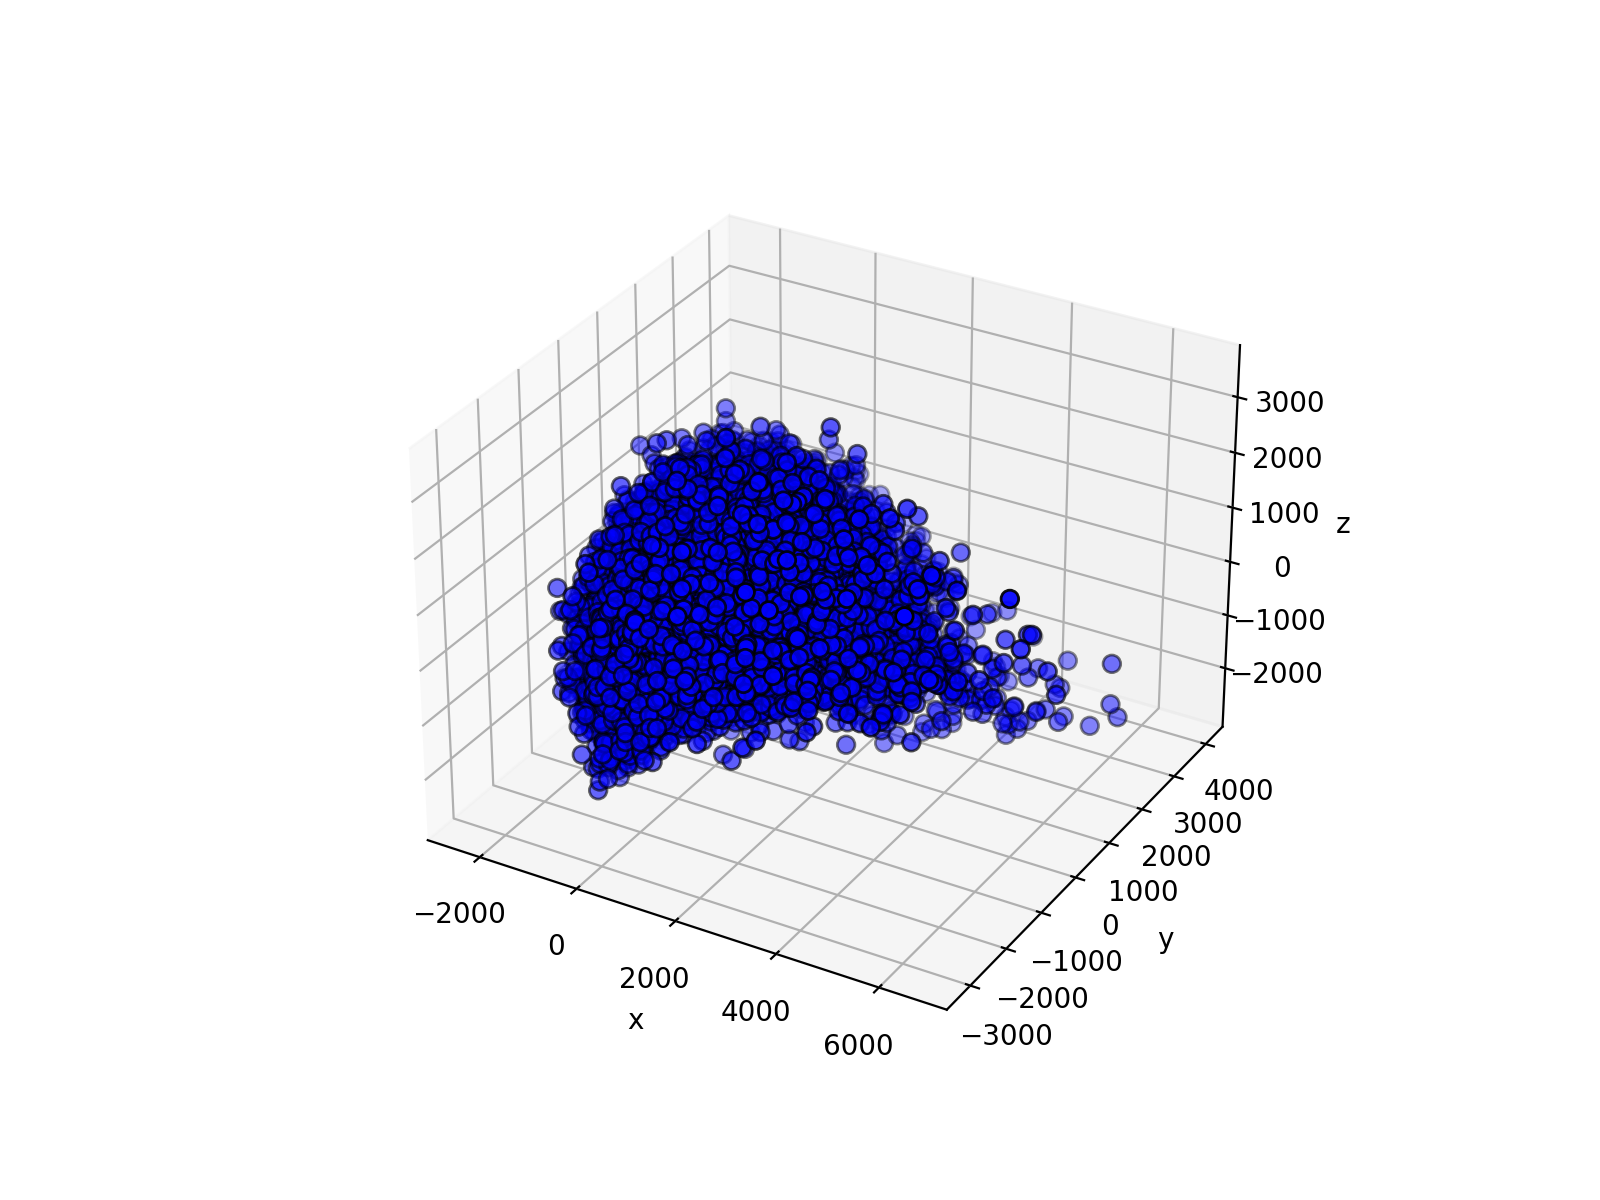

Text(0.5, 0, 'z')

In [67]:
%matplotlib notebook

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    reduced[:, 0],
    reduced[:, 1],
    reduced[:, 2],
    c='b',
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Apply k-means

Apply k-means clustering algorithm on PCA reduced data.

In [68]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(reduced)

Extract labels.

In [69]:
labels = kmeans.labels_
labels

array([0, 1, 2, ..., 2, 1, 2], dtype=int32)

Predict cluster association.

In [70]:
predicted = kmeans.predict(reduced)
predicted.min(), predicted.max()

(0, 2)

Compute cluster centers.

In [71]:
centers = kmeans.cluster_centers_
centers

array([[1970.65370784,   66.56753952,   71.43462835],
       [-744.74216843, 1373.10163619,  277.69039194],
       [-488.08332766, -846.14370685, -198.47844317]])

Create associated color array.

In [72]:
colors = np.arange(0, n_clusters, 1)
colors

array([0, 1, 2])

Plot PCA reduced data and cluster centers, using cluster association color-coding.

<IPython.core.display.Javascript object>


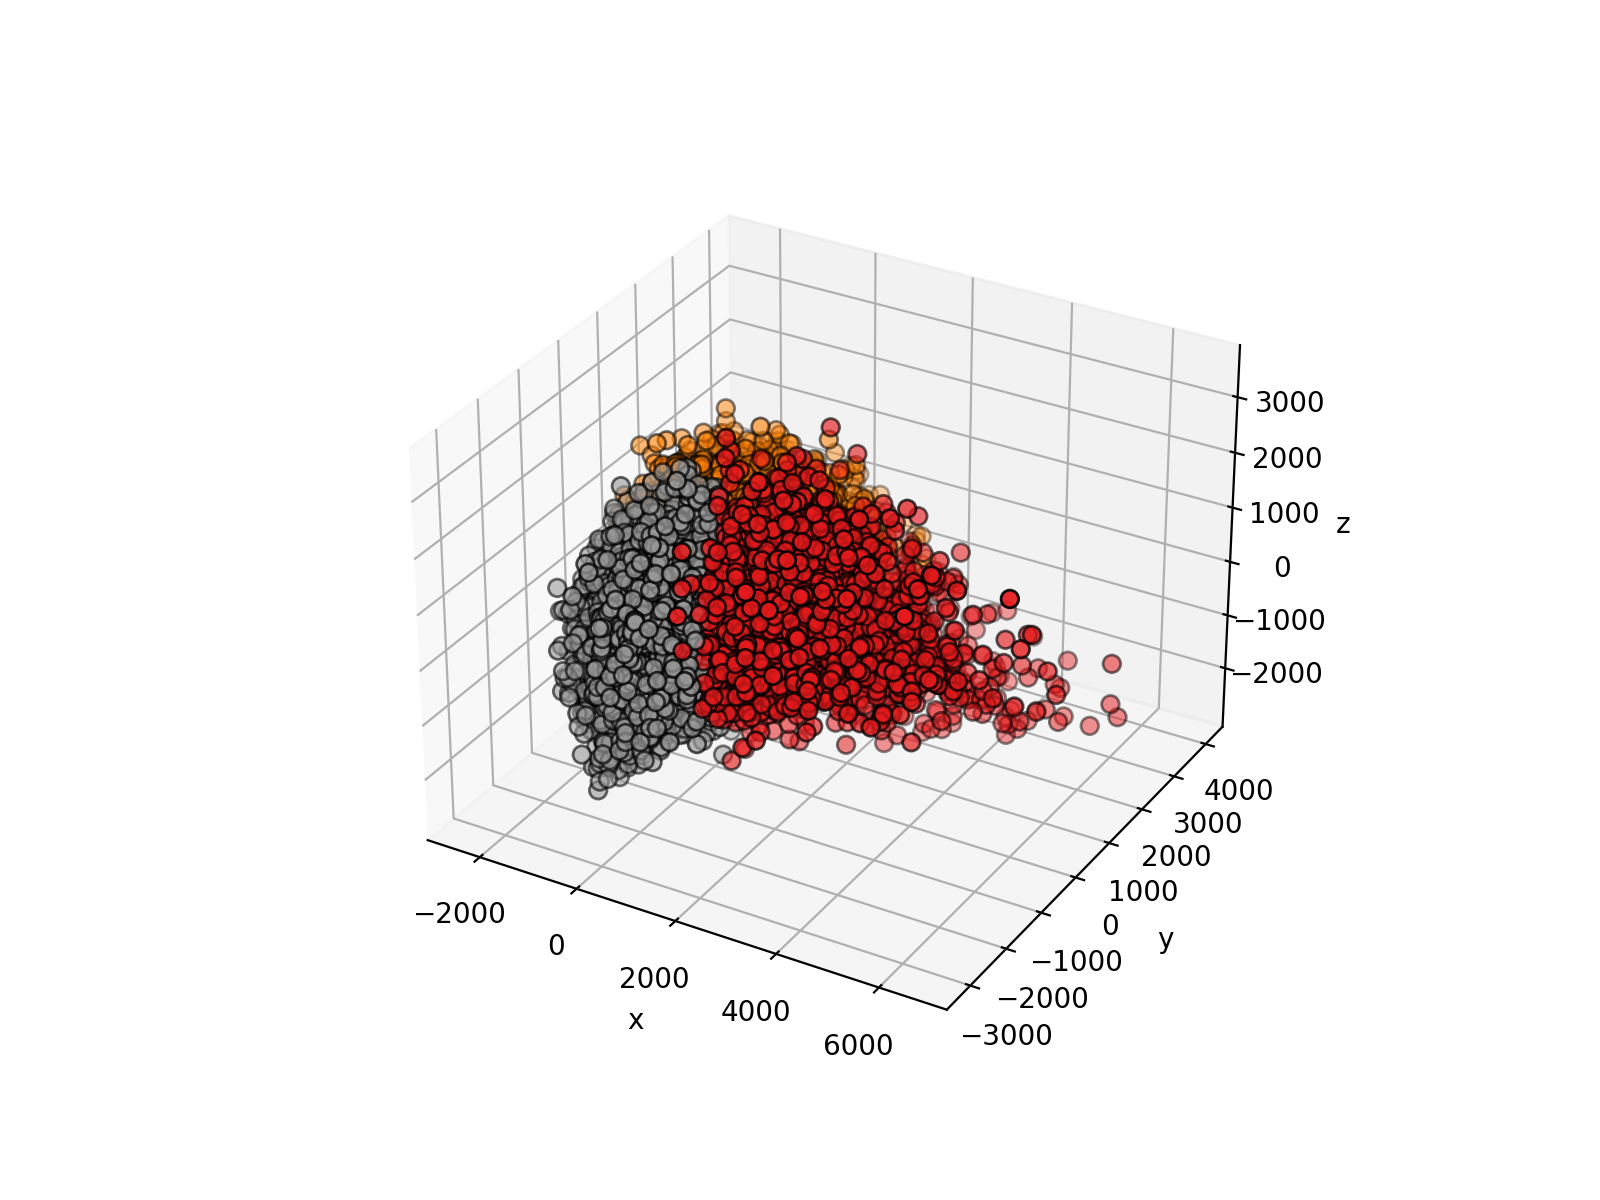

In [76]:
from matplotlib.lines import Line2D

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    reduced[:, 0],
    reduced[:, 1],
    reduced[:, 2],
    c=predicted.astype(float),
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

ax.scatter(
    centers[:, 0],
    centers[:, 1],
    centers[:, 2],
    marker='*',
    c=colors,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=200,
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

'''
for c in np.unique(predicted):
    print(c, c.astype(float))
    ax.scatter(0,0,0, label=c, marker='o', s=15, c=c.astype(float), cmap=plt.cm.Set1, edgecolor="k")
ax.legend(loc=0)
'''
    
plt.show()

## Visualise images from each cluster

Let's display a few images associated with each cluster in order to understand which features were learned by the model, and label the clusters with human-readable naming. 

**NdA:** pandas complains about mismatching colum lenghts due to "index" and "data" being empty. I have removed manually these columns from the file.

In [77]:
filename = '../data/latent_space/SimCLR/labels.json'

imgname = pd.read_json(filename)
imgname.rename(columns={'columns': 'image'}, inplace=True)
imgname.head()

,image
0,P05_003152_1956_XI_15N287W_2120.png
1,F10_039760_1777_XN_02S006W_1115.png
2,F10_039760_1777_XN_02S006W_1925.png
3,P04_002730_1984_XI_18N287W_4167.png
4,P17_007767_1972_XN_17N288W_990.png


Assuming that the embeddings and labels files are ordinately written, meaning that each element index correspond between the two files, we can visualise a sample of images associated with each cluster. First let's convert the predicted array into a pandas DF.

In [78]:
clustered = pd.DataFrame(predicted, columns=['cluster'])
clustered.head()

,cluster
0,0
1,1
2,2
3,0
4,2


Now we can join row-wise the two database, cluster association and image name.

In [79]:
associations = pd.concat([clustered, imgname], axis=1)
associations.head()

,cluster,image
0,0,P05_003152_1956_XI_15N287W_2120.png
1,1,F10_039760_1777_XN_02S006W_1115.png
2,2,F10_039760_1777_XN_02S006W_1925.png
3,0,P04_002730_1984_XI_18N287W_4167.png
4,2,P17_007767_1972_XN_17N288W_990.png


Now we can display the first **ground truth** images in each cluster.

<IPython.core.display.Javascript object>


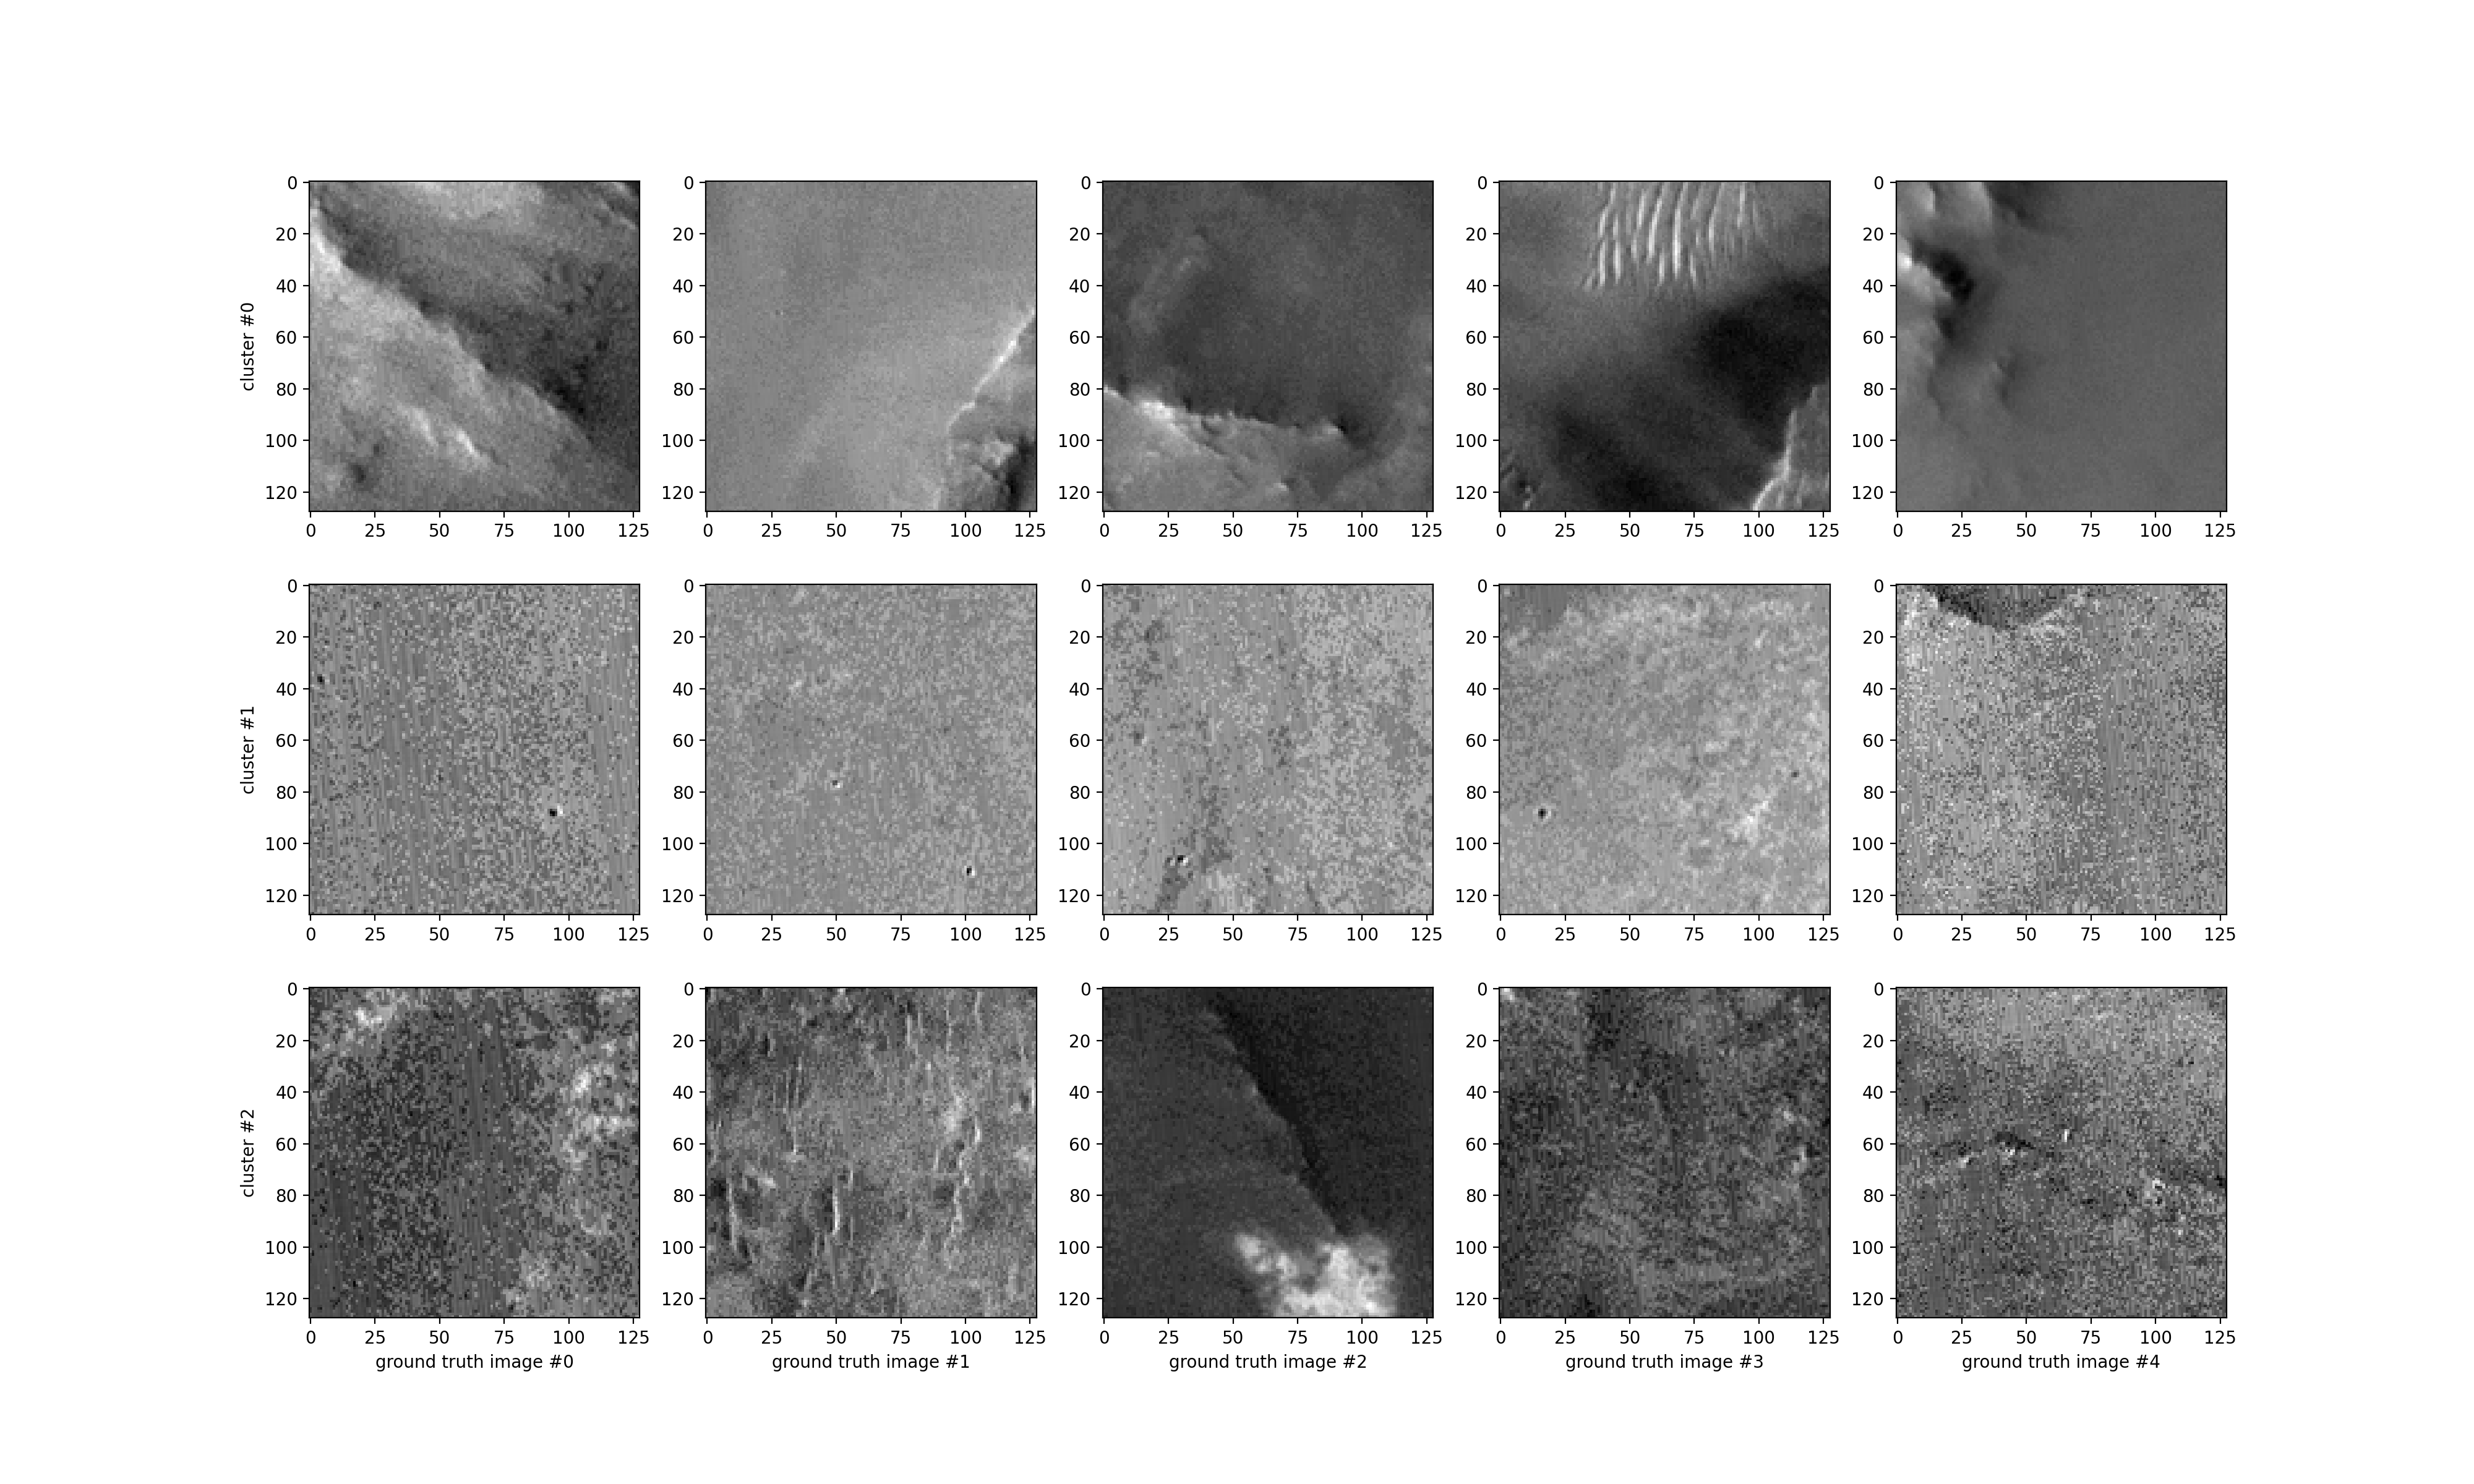

In [83]:
fig, axes = plt.subplots(ncols=5, nrows=n_clusters, figsize=(20, 4*n_clusters))

for c in colors:
    indexes = associations[associations['cluster']==c].head().index
    axes[c][0].set_ylabel(f'cluster #{c}')
    for i, idx in enumerate(indexes):
        png = join(modelpath, 'images', associations[associations['cluster']==c]['image'][idx])
        img = mpimg.imread(png)
        axes[c][i].imshow(img)
        axes[colors[-1]][i].set_xlabel(f'ground truth image #{i}')
    
plt.show()

And now we can do the same for the generated features map.

<IPython.core.display.Javascript object>


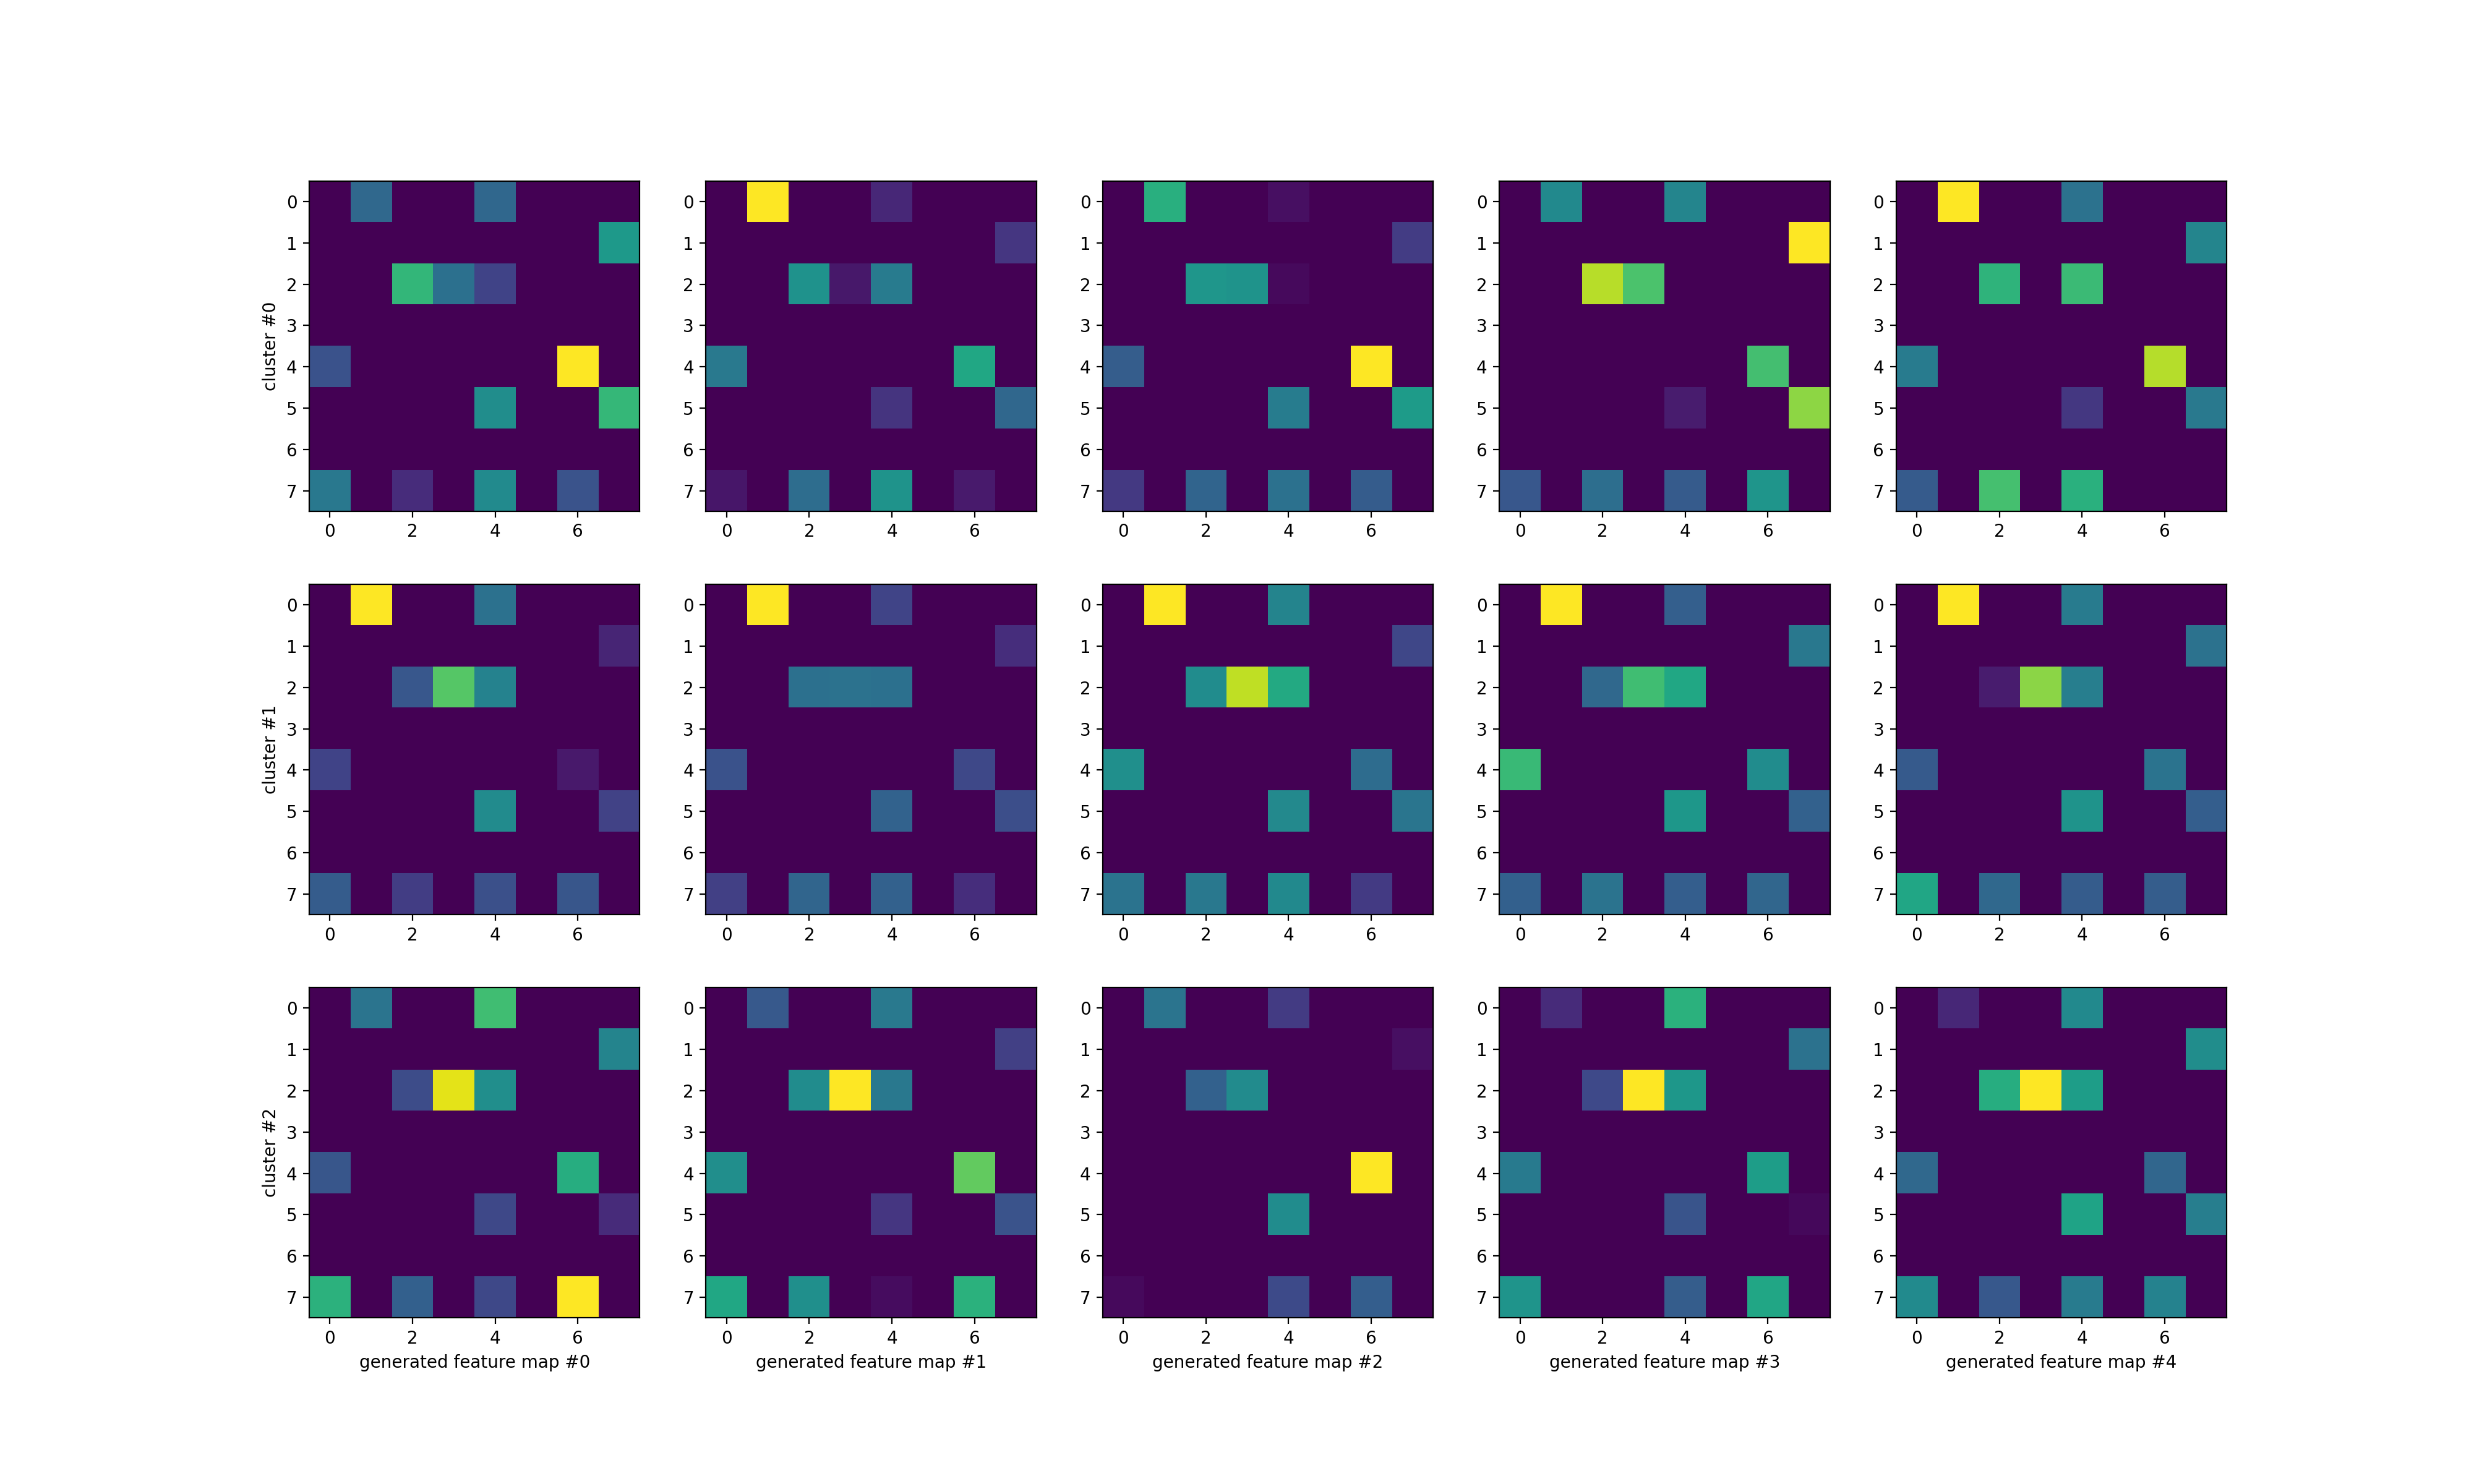

In [84]:
fig, axes = plt.subplots(ncols=5, nrows=n_clusters, figsize=(20, 4*n_clusters))

for c in colors:
    indexes = associations[associations['cluster']==c].head().index
    axes[c][0].set_ylabel(f'cluster #{c}')
    for i, idx in enumerate(indexes):
        png = join(modelpath, 'generated', associations[associations['cluster']==c]['image'][idx])
        img = mpimg.imread(png)
        axes[c][i].imshow(img)
        axes[colors[-1]][i].set_xlabel(f'generated feature map #{i}')
    
plt.show()